#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import os
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder
from stylized_module.point_current import Point_current

mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_standard.csv'
tstop = 20.  # ms
dt = 0.025  # ms. does not allow change

h.load_file('stdrun.hoc')
h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
#h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt

Define cell model and simulation model. Edit method "set_channels" to design biophysical properties.

In [2]:
class Cell(Stylized_Cell):
    """Define single cell model using parent class Stylized_Cell"""
    def __init__(self,geometry=None,biophys=None,dL=30,vrest=-70.0):
        """
        Initialize cell model
        geometry: pandas dataframe of cell morphology properties
        biophys: vector of biophysical parameters corresponding to "biophys_entries". Use -1 for default value.
        dL: maximum segment length
        vrest: reversal potential for leak channels
        """
        self.biophys = biophys
        super().__init__(geometry,dL,vrest)
        self.record_soma_v() # uncomment this if want to record soma voltage
    
    def set_channels(self):
        """Define biophysical properties, insert channels"""
        self.define_biophys_entries()
        # common parameters
        for sec in self.all:
            sec.cm = 2.0
            sec.Ra = 100
            sec.insert('pas')
            sec.e_pas = self._vrest
        # fixed parameters
        soma = self.soma
        soma.cm = 1.0
        soma.insert('NaTa_t')  # Sodium channel
        soma.insert('SKv3_1')  # Potassium channel
        soma.ena = 50
        soma.ek = -85
        for isec in self.grp_ids[2]:
            sec = self.get_sec_by_id(isec)  # apical dendrites
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.ena = 50
            sec.ek = -85
        # variable parameters
        for i,entry in enumerate(self.biophys_entries):
            for sec in self.get_sec_by_id(self.grp_ids[entry[0]]):
                setattr(sec,entry[1],self.biophys[i])
        h.v_init = self._vrest
    
    def define_biophys_entries(self):
        """
        Define list of entries of biophysical parameters.
        Each entry is a pair of group id and parameter reference string.
        Define default values and set parameters in "biophys".
        """
        self.grp_sec_type_ids = [[0],[1,2],[3,4]]  # select section id's for each group
        self.grp_ids = []  # get indices of sections for each group
        for ids in self.grp_sec_type_ids:
            secs = []
            for i in ids:
                secs.extend(self.sec_id_lookup[i])
            self.grp_ids.append(secs)
        self.biophys_entries = [
            (0,'g_pas'),(1,'g_pas'),(2,'g_pas'),  # g_pas of soma, basal, apical 
            (0,'gNaTa_tbar_NaTa_t'),(2,'gNaTa_tbar_NaTa_t'),  # gNaTa_t of soma, apical 
            (0,'gSKv3_1bar_SKv3_1'),(2,'gSKv3_1bar_SKv3_1')  # gSKv3_1 of soma, apical 
        ]
        # g_pas 0.00002-0.00005, 0.00003-0.00015, 0.00003-0.00015
        # gNaTa_t 1.0-4.0, 0.008-0.04
        # gSKv3_1 0.3-2.0, 0-0.04
        default_biophys = np.array([0.0000338,0.0000467,0.0000589,2.04,0.0213,0.693,0.000261])
        if self.biophys is not None:
            for i in range(len(self.biophys)):
                if self.biophys[i]>=0:
                    default_biophys[i]=self.biophys[i]
        self.biophys = default_biophys
    
    def add_synapse(self,stim,sec_index,**kwargs):
        """Add synapse to a section by its index"""
        self.injection.append(Synapse(self,stim,sec_index,**kwargs))
    
    def record_soma_v(self):
        self.v_rec = Recorder(self.soma(.5),'v')
    
    def v(self):
        """Return recorded soma membrane voltage in numpy array"""
        if hasattr(self,'v_rec'):
            return self.v_rec.as_numpy()

class Synapse(Point_current):
    def __init__(self,cell,stim,sec_index,gmax=0.01,loc=0.5,record=True):
        super().__init__(cell,sec_index,loc)
        self.stim = stim
        self.gmax = gmax
        self.pp_obj = h.AlphaSynapse1(self.get_section()(loc))
        self.setup(record)
    
    def setup(self,record):
        self.setup_synapse()
        if record:
            self.setup_recorder()
    
    def setup_synapse(self):
        syn = self.pp_obj
        syn.e = 0.  # mV. Reversal potential
        syn.tau = 5.0  # ms. Synapse time constant
        syn.gmax = self.gmax  # uS. maximum conductance
        self.nc = h.NetCon(self.stim,syn,1,0,1)

class Simulation(object):
    def __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],geo_param=[-1],biophys=[-1],gmax=0.015,scale=1.0,ncell=1):
        """
        Initialize simulation object
        geometry: pandas dataframe of cell morphology properties
        electrodes: array of electrode coordinates, n-by-3
        loc_param: location parameters, ncell-by-6 array, (x,y,z,theta,h,phi)
        geo_param: geometry parameters, ncell-by-k array, if not specified, use default properties in geometry
        biophys: biophysical parameters, ncell-by-k array, if not specified, use default properties
        gmax: maximum conductance of synapse, ncell-vector, if is single value, is constant for all cells
        scale: scaling factors of lfp magnitude, ncell-vector, if is single value, is constant for all cells
        ncell: number of cells in the simulation, required if simulating for multiple cells
        """
        self.ncell = ncell  # number of cells in this simulation
        self.cells = []  # list of cell object
        self.lfp = []  # list of EcpMod object
        self.define_geometry_entries()  # list of entries to geometry dataframe
        self.geometry = geometry.copy()
        self.electrodes = electrodes
        self.set_loc_param(loc_param)
        self.set_geo_param(geo_param)
        self.set_biophys(biophys)
        self.set_gmax(gmax)
        self.set_scale(scale)
        self.set_netstim()
        self.create_cells()  # create cell objects with properties set up
        self.t_vec = h.Vector( round(h.tstop/h.dt)+1 ).record(h._ref_t)  # record time
    
    def set_netstim(self):
        """Setup synaptic input event"""
        stim = h.NetStim()
        stim.number = 1  # only one event
        stim.start = 0.1 # delay
        self.stim = stim
    
    def pack_parameters(self,param,ndim,param_name):
        """Pack parameters for the simulation"""
        if ndim==0:
            if not hasattr(param,'__len__'):
                param = [param]
            param = np.array(param).ravel()
            if param.size!=self.ncell:
                if param.size==1:
                    param = np.broadcast_to(param,self.ncell)
                else:
                    raise ValueError(param_name+" size does not match ncell")   
        if ndim==1:
            param = np.array(param)
            if param.ndim==1:
                param = np.expand_dims(param,0)
            if param.shape[0]!=self.ncell:
                if param.shape[0]==1:
                    param = np.broadcast_to(param,(self.ncell,param.shape[1]))
                else:
                    raise ValueError(param_name+" number of rows does not match ncell")
        return param
    
    def set_loc_param(self,loc_param):
        """Setup location parameters. loc_param ncell-by-6 array"""
        loc_param = self.pack_parameters(loc_param,1,"loc_param")
        self.loc_param = [(loc_param[i,:3],loc_param[i,3:]) for i in range(self.ncell)]
    
    def set_geo_param(self,geo_param):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.geo_param = self.pack_parameters(geo_param,1,"geo_param")
    
    def set_biophys(self,biophys):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.biophys = self.pack_parameters(biophys,1,"biophys")
    
    def set_gmax(self,gmax):
        """Setup maximum conductance of synapse"""
        self.gmax = self.pack_parameters(gmax,0,"gmax")
    
    def set_scale(self,scale):
        """setup scaling factors of lfp magnitude"""
        self.scale = self.pack_parameters(scale,0,"scale")
    
    def define_geometry_entries(self):
        """Define list of entries to geometry dataframe. Each entry is a pair of section id and property."""
        self.geo_entries = [
            (0,'R'),  # change soma radius
            (3,'L'),  # change trunk length
            (3,'R'),  # change trunk radius
            ([1,2],'R'),  # change basal dendrites radius
            (4,'R'),  # change tuft radius
            ([1,2,4],'L') # change all dendrites length
        ]
    
    def set_geometry(self,geometry,geo_param):
        """Set property values from geo_param through each entry to geometry. Return dataframe"""
        geom = geometry.copy()
        for i,x in enumerate(geo_param):
            if x>=0:
                geom.loc[self.geo_entries[i]] = x
        return geom
    
    def create_cells(self):
        """Create cell objects with properties set up"""
        self.cells.clear()  # remove cell objects from previous run
        self.lfp.clear()
        # Create cell with morphology and biophysical parameters
        for i in range(self.ncell):
            geometry = self.set_geometry(self.geometry,self.geo_param[i,:])
            self.cells.append( Cell(geometry=geometry,biophys=self.biophys[i,:]) )
        # add injection current or synaptic current and set up lfp recording
        min_dist = 10.0 # minimum distance allowed between segment and electrode. Set to None if not using.
        for i,cell in enumerate(self.cells):
#             # Pulse injection
#             cell.add_injection(sec_index=0,record=True,delay=0.1,dur=0.2,amp=5.0) # Tune for proper action potential
            # Synpatic input
            cell.add_synapse(self.stim,sec_index=0,gmax=self.gmax[i])
            # Move cell location
            self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i],min_distance=min_dist) )
    
    def run(self):
        """Run simulation"""
        h.run()
    
    def t(self):
        """Return simulation time vector"""
        return self.t_vec.as_numpy()
    
    def get_lfp(self,index=0):
        """Return LFP array of the cell by index (indices), (cells-by-)channels-by-time"""
        if not hasattr(index,'__len__'):
            lfp = self.lfp[index].calc_ecp()
        else:
            index = np.asarray(index).ravel()
            lfp = np.stack([self.lfp[i].calc_ecp() for i in index],axis=0)
        return lfp
    

#### Create simulation

In [3]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

Set parameters

In [4]:
loc_param = [0,0,50,0.2,0.75,1.5]  # example position
geo_param = [-1,-1,-1]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])
# example of changing biophysical parameters (check "biophys_entries" in "Cell" class for meaning, bounds can also be found there)
biophys = [-1,-1,0.0000589*3,-1,0.0213*1.5]
sim = Simulation(geo_standard,elec_pos,loc_param,geo_param=geo_param,biophys=biophys,gmax=0.005,scale=100.)  # 0.001 -0.012

Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [5]:
sec_list = sim.cells[0].get_sec_by_id([5,6])
dend_v = Recorder([sec_list[0](0.1),sec_list[0](0.5),sec_list[0](0.9),sec_list[1](0.5)])

In [6]:
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

Plot membrane voltage in soma, trunk and tuft.

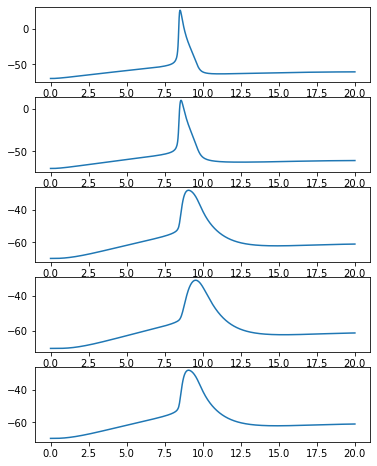

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

v_dend = dend_v.as_numpy()
plt.figure(figsize=(6,8))
plt.subplot(5,1,1)
plt.plot(t,sim.cells[0].v())
for i in range(v_dend.shape[0]):
    plt.subplot(5,1,i+2)
    plt.plot(t,v_dend[i,:])
plt.show()

Use functions in "utils" module to plot

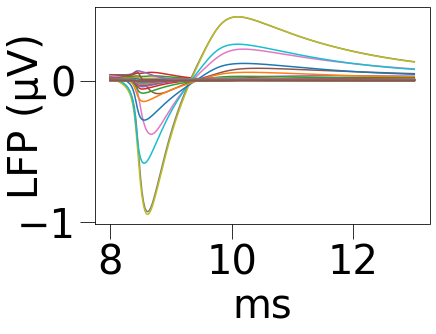

In [8]:
from utils.plot_results import plot_LFP_traces,plot_LFP_heatmap
%matplotlib inline

delay = 8.0
window = [delay,delay+5.01]
# window = [5.,15.01]
idx = (t>=window[0]) & (t<=window[1])  # time index
fig,ax = plot_LFP_traces(t[idx],lfp[idx,:])

D:\reserch_temp\Stylized-Cell-model\utils\plot_results.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(t,elec_d,lfp,cmap=cmap,vmin=vlim[0],vmax=vlim[1])


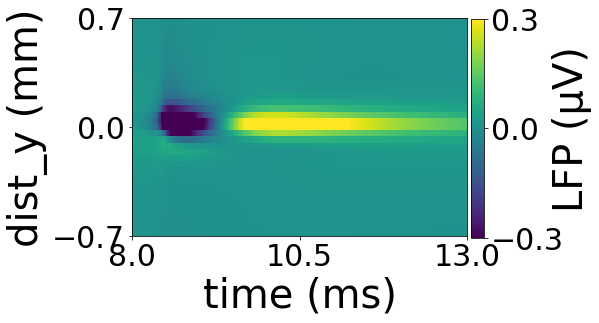

In [9]:
e_idx = slice(30,-30)  # electrodes index
fig,ax = plot_LFP_heatmap(t[idx],pos[e_idx,1],lfp[idx,e_idx],vlim=[-0.3,0.3])
# set narrower "vlim" can help see more subtle difference in voltage

In [10]:
help(plot_LFP_heatmap) # check docstring

Help on function plot_LFP_heatmap in module utils.plot_results:

plot_LFP_heatmap(t, elec_d, lfp, savefig=None, vlim='auto', fontsize=40, ticksize=30, labelpad=-12, nbins=3, cbbox=[0.91, 0.118, 0.03, 0.76], cmap='viridis')
    Plot LFP heatmap.
    t: time points (ms). 1D array
    elec_d: electrode distance (um). 1D array
    lfp: LFP traces (uV). If is 2D array, each column is a channel.
    savefig: if specified as string, save figure with the string as file name.
    vlim: value limit for color map, using +/- 3-sigma of lfp for bounds as default. Use 'max' for maximum bound range.

